In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
import warnings

warnings.simplefilter("ignore")

In [2]:
def qc(adata, mt_threshold_pct=20, min_genes=500, max_counts=30000, min_cells=3):
    """
    Basic quality control: filters low-quality cells and genes.
    """
    adata = adata.copy()
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p=False, inplace=True)
    adata = adata[adata.obs['pct_counts_mt'] < mt_threshold_pct, :].copy()
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, max_counts=max_counts)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    return adata

def standardize_chromosomes(adata):
    """
    Retain only standard chromosomes (1-22, X, Y) as strings.
    """
    adata = adata.copy()
    adata.var['chromosome'] = adata.var['chromosome'].astype(str)
    std_chroms = [str(i) for i in range(1, 23)] + ['X', 'Y']
    return adata[:, adata.var['chromosome'].isin(std_chroms)].copy()

def preprocess(adata):
    """
    Normalize expression to 10,000 total counts per cell.
    Store original counts in `.layers["counts"]`.
    """
    adata = adata.copy()
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    return adata

def identify_diploid_cells_high_precision(adata,
                                           window=100,
                                           n_components=3,
                                           n_pcs=20,
                                           distance_trim_percentile=70,
                                           chr_filter='X',
                                           chr_filter_percentile=80):
    """
    High-precision diploid cell detection using:
    - PCA + GMM clustering
    - Variance- and distance-based filtering
    - Optional exclusion of cells overexpressing CNV-prone regions (e.g. chrX)
    """
    expr_raw = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    expr_df = pd.DataFrame(expr_raw, index=adata.obs_names, columns=adata.var_names)
    gene_order = adata.var.sort_values(['chromosome', 'start']).index
    expr_df = expr_df[gene_order]

    # Freeman-Tukey transform
    expr_ft = np.log2(np.sqrt(expr_df) + np.sqrt(expr_df + 1))

    # Smooth expression along genome
    expr_smooth = expr_ft.T.rolling(window=window, min_periods=1, center=True).mean().dropna().T
    expr_smooth = expr_smooth.loc[:, ~expr_smooth.columns.duplicated()]

    # PCA
    pca = PCA(n_components=n_pcs)
    pcs = pca.fit_transform(expr_smooth)

    # GMM clustering
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    labels = gmm.fit_predict(pcs)

    # Select diploid cluster with smallest composite score = variance × size
    cluster_variances = [expr_smooth.iloc[labels == i].var(axis=1).mean() for i in range(n_components)]
    cluster_sizes = [np.sum(labels == i) for i in range(n_components)]
    composite_score = [v * s for v, s in zip(cluster_variances, cluster_sizes)]
    diploid_cluster = np.argmin(composite_score)

    # Extract diploid cluster and filter tightly around center
    diploid_indices = np.where(labels == diploid_cluster)[0]
    diploid_pcs = pcs[diploid_indices]
    center = diploid_pcs.mean(axis=0).reshape(1, -1)
    distances = cdist(diploid_pcs, center).flatten()
    dist_thresh = np.percentile(distances, distance_trim_percentile)
    confident_diploid_indices = diploid_indices[distances <= dist_thresh]

    # Final diploid prediction mask
    diploid_pred = np.zeros(pcs.shape[0], dtype=bool)
    diploid_pred[confident_diploid_indices] = True

    # Optional: filter out diploids overexpressing a known CNV-prone chromosome
    if chr_filter is not None:
        chr_genes = adata.var_names[adata.var['chromosome'] == chr_filter]
        chr_mean_expr = adata[:, chr_genes].X.mean(axis=1)
        if hasattr(chr_mean_expr, "A1"):
            chr_mean_expr = chr_mean_expr.A1
        chr_high_expr = chr_mean_expr > np.percentile(chr_mean_expr, chr_filter_percentile)
        diploid_pred = diploid_pred & (~chr_high_expr)

    return diploid_pred, labels

def evaluate_predictions(adata, diploid_pred):
    """
    Compare predicted diploids vs. simulated CNV ground truth.
    Returns: precision, recall, F1 score.
    """
    true_diploid = adata.obs['simulated_cnvs'].astype(str).replace(['', 'nan', 'NaN'], np.nan).isna()
    tp = np.sum((diploid_pred == True) & (true_diploid == True))
    fp = np.sum((diploid_pred == True) & (true_diploid == False))
    fn = np.sum((diploid_pred == False) & (true_diploid == True))
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1


In [3]:
# Load and sanitize CNV labels
adata = sc.read_h5ad("/Users/pythonpete/Downloads/PBMC_simulated_cnas_041025.h5ad")
adata.obs['simulated_cnvs'] = adata.obs['simulated_cnvs'].astype(str).replace(['', 'nan', 'NaN'], np.nan)

# Apply preprocessing steps
adata = standardize_chromosomes(adata)
adata = qc(adata)
adata = preprocess(adata)

# Run high-precision diploid detection
diploid_pred, labels = identify_diploid_cells_high_precision(
    adata,
    window=100,
    n_components=3,
    distance_trim_percentile=70,
    chr_filter='X',
    chr_filter_percentile=80
)

# Store predictions in obs
adata.obs['predicted_diploid'] = diploid_pred
adata.obs['gmm_cluster'] = labels.astype(str)

# Evaluate performance
precision, recall, f1 = evaluate_predictions(adata, diploid_pred)
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}")


Precision: 0.999 | Recall: 0.170 | F1 Score: 0.290


In [4]:
# Count number of diploid predictions
n_diploid = adata.obs['predicted_diploid'].sum()
total = adata.n_obs
print(f"Predicted diploid cells: {n_diploid} / {total} ({100 * n_diploid / total:.1f}%)")


Predicted diploid cells: 1073 / 10307 (10.4%)


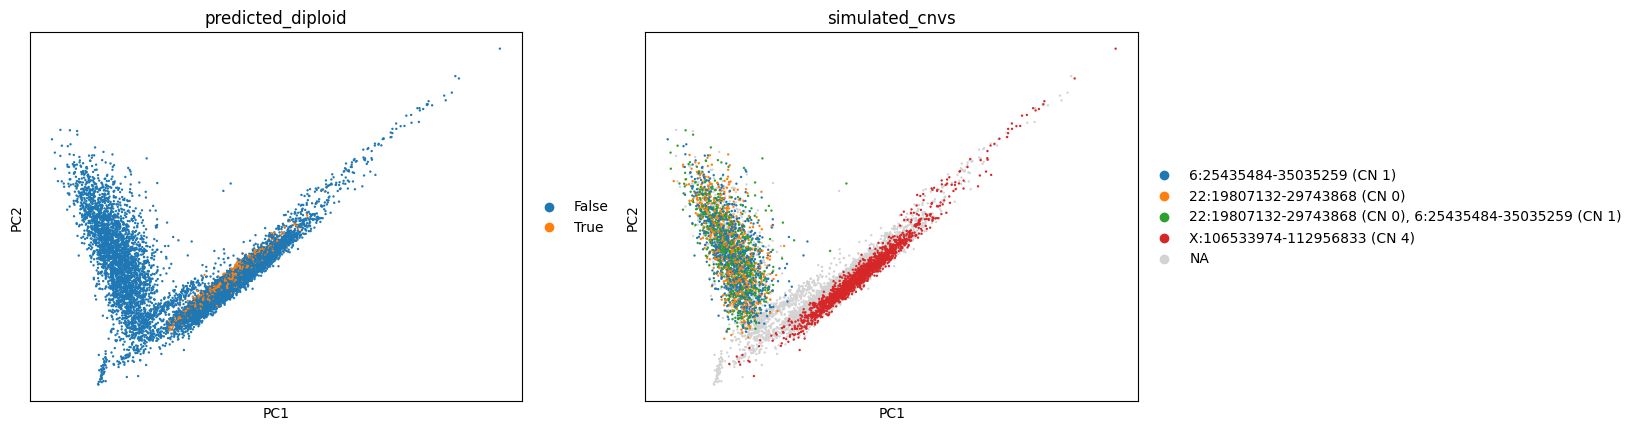

In [5]:
sc.tl.pca(adata)
sc.pl.pca(adata, color=["predicted_diploid", "simulated_cnvs"])


In [6]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,n_genes,n_counts,cell_type,simulated_cnvs,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,predicted_diploid,gmm_cluster
AAACCCAAGCGCCCAT-1,986,1728.0,392.0,17.785845,0.0,0.0,986,1728.0,CD4 T cell,NaN,34.548611,42.071759,53.645833,71.875000,False,0
AAACCCAAGGTTCCGC-1,4035,13666.0,4526.0,22.528622,0.0,0.0,4035,13666.0,Dendritic,NaN,27.959900,35.401727,43.707010,57.097907,False,2
AAACCCACAGAGTTGG-1,1715,4152.0,1043.0,17.726036,0.0,0.0,1715,4152.0,CD14 monocyte,22:19807132-29743868 (CN 0),39.956647,46.724470,54.865125,70.158960,False,2
AAACCCACAGGTATGG-1,2098,4295.0,742.0,13.417721,0.0,0.0,2098,4295.0,NK cell,NaN,30.407451,36.623981,44.842841,60.209546,False,0
AAACCCACATAGTCAC-1,1488,2744.0,1734.0,33.960049,0.0,0.0,1488,2744.0,B cell,NaN,29.409621,36.588921,46.355685,63.994169,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGCGTCGT-1,1225,2248.0,2471.0,48.308895,0.0,0.0,1225,2248.0,CD4 T cell,NaN,36.032028,43.016014,52.179715,67.749110,False,0
TTTGTTGGTGTCATGT-1,1226,2523.0,606.0,15.392430,0.0,0.0,1226,2523.0,CD14 monocyte,"22:19807132-29743868 (CN 0), 6:25435484-350352...",36.741974,44.391597,54.340071,71.224732,False,2
TTTGTTGGTTTGAACC-1,1286,2433.0,1402.0,33.027092,0.0,0.0,1286,2433.0,CD8 T cell,NaN,35.963831,42.663379,51.582409,67.694205,False,0
TTTGTTGTCCAAGCCG-1,1546,3026.0,1985.0,35.433773,0.0,0.0,1546,3026.0,CD4 T cell,X:106533974-112956833 (CN 4),34.534038,40.846001,49.603437,65.432915,False,0


In [7]:
def get_error_rates_per_cnv(adata, mode='fp', verbose=True):
    """
    Calculates the per-CNV false positive or false negative rates.

    Parameters
    ----------
    adata : AnnData
        Annotated single-cell object with:
        - adata.obs['predicted_diploid'] : bool indicating predicted diploid status
        - adata.obs['simulated_cnvs'] : ground truth CNV label (NaN if diploid)
    
    mode : str, optional
        'fp' (default): false positives — predicted diploid, but actually CNV.
        'fn'          : false negatives — predicted non-diploid, but actually diploid.
    
    verbose : bool, optional
        Whether to print the result (default is True).

    Returns
    -------
    pd.Series
        Sorted false error rates (false rate per CNV type).
    """
    assert mode in ['fp', 'fn'], "mode must be 'fp' or 'fn'"
    
    # Clean simulated CNV column
    cnv_col = adata.obs['simulated_cnvs'].astype(str).replace(['', 'nan', 'NaN'], np.nan)

    # Mask for CNV-labeled cells
    has_cnv = cnv_col.notna()

    if mode == 'fp':
        # Predicted diploid, but actually has CNV
        error_mask = adata.obs['predicted_diploid'] & has_cnv
        label = "False Positive"
    else:  # 'fn'
        # Predicted non-diploid, but actually is diploid
        error_mask = (~adata.obs['predicted_diploid']) & (~has_cnv)
        label = "False Negative"

    # Get CNV labels of error cells
    error_cnv_labels = cnv_col[error_mask]

    # Count errors and total occurrences per CNV type
    error_counts = error_cnv_labels.value_counts()
    total_counts = cnv_col[has_cnv].value_counts()

    # Compute and sort rates
    error_rates = (error_counts / total_counts).sort_values(ascending=False)

    if verbose:
        print(f"\n{label} Rates by CNV Type:\n")
        print(error_rates)

    return error_rates

In [8]:
# False positive rate per CNV type (your priority)
get_error_rates_per_cnv(adata, mode='fp')


False Positive Rates by CNV Type:

simulated_cnvs
X:106533974-112956833 (CN 4)                               0.000578
22:19807132-29743868 (CN 0)                                     NaN
22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)         NaN
6:25435484-35035259 (CN 1)                                      NaN
Name: count, dtype: float64


simulated_cnvs
X:106533974-112956833 (CN 4)                               0.000578
22:19807132-29743868 (CN 0)                                     NaN
22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)         NaN
6:25435484-35035259 (CN 1)                                      NaN
Name: count, dtype: float64

In [9]:
# Create column with boolean True/False for predicted diploids
adata.obs['predicted_diploid'] = pd.Series(diploid_pred, index=adata.obs_names)

In [10]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,n_genes,n_counts,cell_type,simulated_cnvs,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,predicted_diploid,gmm_cluster
AAACCCAAGCGCCCAT-1,986,1728.0,392.0,17.785845,0.0,0.0,986,1728.0,CD4 T cell,NaN,34.548611,42.071759,53.645833,71.875000,False,0
AAACCCAAGGTTCCGC-1,4035,13666.0,4526.0,22.528622,0.0,0.0,4035,13666.0,Dendritic,NaN,27.959900,35.401727,43.707010,57.097907,False,2
AAACCCACAGAGTTGG-1,1715,4152.0,1043.0,17.726036,0.0,0.0,1715,4152.0,CD14 monocyte,22:19807132-29743868 (CN 0),39.956647,46.724470,54.865125,70.158960,False,2
AAACCCACAGGTATGG-1,2098,4295.0,742.0,13.417721,0.0,0.0,2098,4295.0,NK cell,NaN,30.407451,36.623981,44.842841,60.209546,False,0
AAACCCACATAGTCAC-1,1488,2744.0,1734.0,33.960049,0.0,0.0,1488,2744.0,B cell,NaN,29.409621,36.588921,46.355685,63.994169,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGCGTCGT-1,1225,2248.0,2471.0,48.308895,0.0,0.0,1225,2248.0,CD4 T cell,NaN,36.032028,43.016014,52.179715,67.749110,False,0
TTTGTTGGTGTCATGT-1,1226,2523.0,606.0,15.392430,0.0,0.0,1226,2523.0,CD14 monocyte,"22:19807132-29743868 (CN 0), 6:25435484-350352...",36.741974,44.391597,54.340071,71.224732,False,2
TTTGTTGGTTTGAACC-1,1286,2433.0,1402.0,33.027092,0.0,0.0,1286,2433.0,CD8 T cell,NaN,35.963831,42.663379,51.582409,67.694205,False,0
TTTGTTGTCCAAGCCG-1,1546,3026.0,1985.0,35.433773,0.0,0.0,1546,3026.0,CD4 T cell,X:106533974-112956833 (CN 4),34.534038,40.846001,49.603437,65.432915,False,0


In [11]:
# Step 1: Subset to only CD14 monocytes
cd14_monocytes = adata.obs['cell_type'].str.contains("CD14", case=False, na=False)

# Step 2: Subset to those predicted as diploid
predicted_diploid = adata.obs['predicted_diploid'] == True

# Step 3: Combine masks
cd14_diploids = adata[cd14_monocytes & predicted_diploid].copy()

# Step 4: Output count
print(f"Number of CD14+ monocytes predicted as diploid: {cd14_diploids.n_obs}")


Number of CD14+ monocytes predicted as diploid: 0
